In [1]:
import cv2, random, os
from trim_dataset import TrimDataset
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [2]:
def data_to_dict(image, bbox, class_id):
    return {"image":image, "bbox": bbox,"class":class_id}


In [3]:
def preprocess_images(images):
    """
    Pré-processa uma lista de imagens lidas com cv2.imread para uso em TensorFlow.
    :param images: Lista de imagens no formato BGR (uint8) lidas com cv2.
    :return: Imagens normalizadas e convertidas para RGB, no formato float32.
    """
    preprocessed_images = []
    for img in images:
        # Verifica se a imagem é válida
        if img is None:
            raise ValueError("Uma ou mais imagens no dataset são inválidas.")
        
        # Converte de BGR para RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Normaliza os valores para o intervalo [0, 1]
        img_normalized = img_rgb / 255.0
        
        # Converte para float32
        img_float32 = img_normalized.astype(np.float32)
        
        preprocessed_images.append(img_float32)
    
    return np.array(preprocessed_images)

In [4]:
def split_dataset(data, train_ratio=0.8, test_ratio=0.1, validate_ratio=0.1):
    """
    Divide um conjunto de dados (vetor de dicionários) em três subconjuntos: treino, teste e validação,
    com base nas proporções fornecidas.

    :param data: Lista de dicionários contendo os dados.
    :param train_ratio: Proporção dos dados para o conjunto de treino (default: 0.8).
    :param test_ratio: Proporção dos dados para o conjunto de teste (default: 0.1).
    :param validate_ratio: Proporção dos dados para o conjunto de validação (default: 0.1).
    :return: Três listas: (train_data, test_data, validate_data)
    """
    
    # Verificar se as proporções somam 1
    if train_ratio + test_ratio + validate_ratio != 1:
        raise ValueError("As proporções de treino, teste e validação devem somar 1.")

    # Embaralha aleatoriamente os dados
    random.shuffle(data)

    # Calcula os índices para separar os dados
    total_size = len(data)
    train_size = int(train_ratio * total_size)
    test_size = int(test_ratio * total_size)
    validate_size = total_size - train_size - test_size  # Garantir que todos os dados sejam usados

    # Divide os dados
    train_data = data[:train_size]
    test_data = data[train_size:train_size + test_size]
    validate_data = data[train_size + test_size:]

    return train_data, test_data, validate_data

In [5]:
def create_cnn_with_bboxes(input_shape, num_classes)->models.Model:
    """
    Cria uma CNN para classificação e regressão de bounding boxes.
    
    :param input_shape: Dimensões da imagem de entrada (altura, largura, canais).
    :param num_classes: Número de classes para a classificação.
    :return: Modelo CNN compilado.
    """
    inputs = tf.keras.Input(shape=input_shape)

    kernel = (5, 5)
    pool = (2, 2)


    x = layers.Conv2D(16, kernel, activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloco convolucional 1
    x = layers.Conv2D(32, kernel, activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloco convolucional 2
    x = layers.Conv2D(64, kernel, activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloco convolucional 3
    x = layers.Conv2D(128, kernel, activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten para conexão densa
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Saída para classificação
    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)

    # Saída para bounding boxes
    bbox_output = layers.Dense(4, name='bbox_output')(x)

    # Modelo com duas saídas
    model = models.Model(inputs=inputs, outputs=[class_output, bbox_output])

    # Compilação do modelo
    model.compile(
        optimizer='adam',
        loss={
            'class_output': 'categorical_crossentropy',
            'bbox_output': 'mean_squared_error'
        },
        metrics={
            'class_output': 'accuracy',
            'bbox_output': 'mean_squared_error'
        }
    )

    return model

In [6]:
dataset = TrimDataset('normalized_dataset')
images = [data_to_dict(img.content, img.bbox, img.category_id) for img in dataset.images]


In [7]:
input_shape = (224, 224, 3)  # Exemplo de tamanho de imagem
num_classes = 10           # Número de classes no dataset
cnn_model = create_cnn_with_bboxes(input_shape, num_classes)

In [8]:
img_train, img_test, img_validation = split_dataset(images)

x_train = [img['image'] for img in img_train]
x_train = preprocess_images(x_train)

y_train_classes = np.array([img['class'] - 1 for img in img_train]) 
y_train_classes = to_categorical(y_train_classes, num_classes)
y_train_bbox = [img['bbox'] for img in img_train]
y_train_bbox = np.array(y_train_bbox) #/ [224.0, 224.0, 224.0, 224.0]



x_val = [img['image'] for img in img_validation]
x_val = preprocess_images(x_val)

y_val_classes = np.array([img['class'] - 1 for img in img_validation]) 
y_val_classes = to_categorical(y_val_classes, num_classes)
y_val_bbox = [img['bbox'] for img in img_validation]
y_val_bbox = np.array(y_val_bbox) #/ [224.0, 224.0, 224.0, 224.0]

x_test = [img['image'] for img in img_test]
x_test = preprocess_images(x_test)
y_test_classes = np.array([img['class'] - 1 for img in img_test])
y_test_classes = to_categorical(y_test_classes, num_classes)
y_test_bbox = [img['bbox'] for img in img_test]
y_test_bbox = np.array(y_test_bbox) #/ [224.0, 224.0, 224.0, 224.0]

In [9]:
print(x_val.shape)
print(y_train_classes.shape)
print(y_train_classes)
print(y_val_bbox.shape)

(60, 224, 224, 3)
(480, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60, 4)


In [10]:
history = cnn_model.fit(
    x_train,
    {'class_output': y_train_classes, 'bbox_output': y_train_bbox},
    epochs=20,
    batch_size=32,
    validation_data=(x_val, {'class_output': y_val_classes, 'bbox_output': y_val_bbox})
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - bbox_output_loss: 6299.4424 - bbox_output_mean_squared_error: 6299.4424 - class_output_accuracy: 0.1170 - class_output_loss: 11.1833 - loss: 6310.6255 - val_bbox_output_loss: 3056.1636 - val_bbox_output_mean_squared_error: 3021.1545 - val_class_output_accuracy: 0.0833 - val_class_output_loss: 10.1866 - val_loss: 3031.3484
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - bbox_output_loss: 2715.3916 - bbox_output_mean_squared_error: 2715.3916 - class_output_accuracy: 0.0262 - class_output_loss: 12.3037 - loss: 2727.6953 - val_bbox_output_loss: 1697.9661 - val_bbox_output_mean_squared_error: 1677.6515 - val_class_output_accuracy: 0.1000 - val_class_output_loss: 10.1600 - val_loss: 1687.8038
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - bbox_output_loss: 1475.1819 - bbox_output_mean_squared_error: 1475.1819 - class_output_accuracy: 0.1260 - class_output_loss: 10.5767 - loss: 1485.7587 - val_bbox_output_loss: 1423.5203 - val_bbox_

In [11]:
cnn_model.evaluate(
    x_test, 
    {'bbox_output': y_test_bbox, 'class_output': y_test_classes}
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step - bbox_output_loss: 232.3877 - bbox_output_mean_squared_error: 227.4296 - class_output_accuracy: 0.7264 - class_output_loss: 0.9133 - loss: 228.3296


[263.1296081542969,
 1.0137434005737305,
 269.572998046875,
 262.13592529296875,
 0.6833333373069763]

In [12]:
cnn_model.save(os.path.join('models', 'cnn_bounding_box_model.keras'))

In [14]:
predicted_classes, predicted_bboxes = cnn_model.predict(x_test)
print(predicted_bboxes.shape)
print(predicted_classes.shape)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
(60, 4)
(60, 10)


In [15]:
predicted_classes = np.argmax(predicted_classes, axis=1)

true_classes = y_test_classes
class_labels = dataset.categories

In [ ]:
print(predicted_bboxes.shape)
print(predicted_classes)
print(true_classes)

KeyError: np.int64(0)

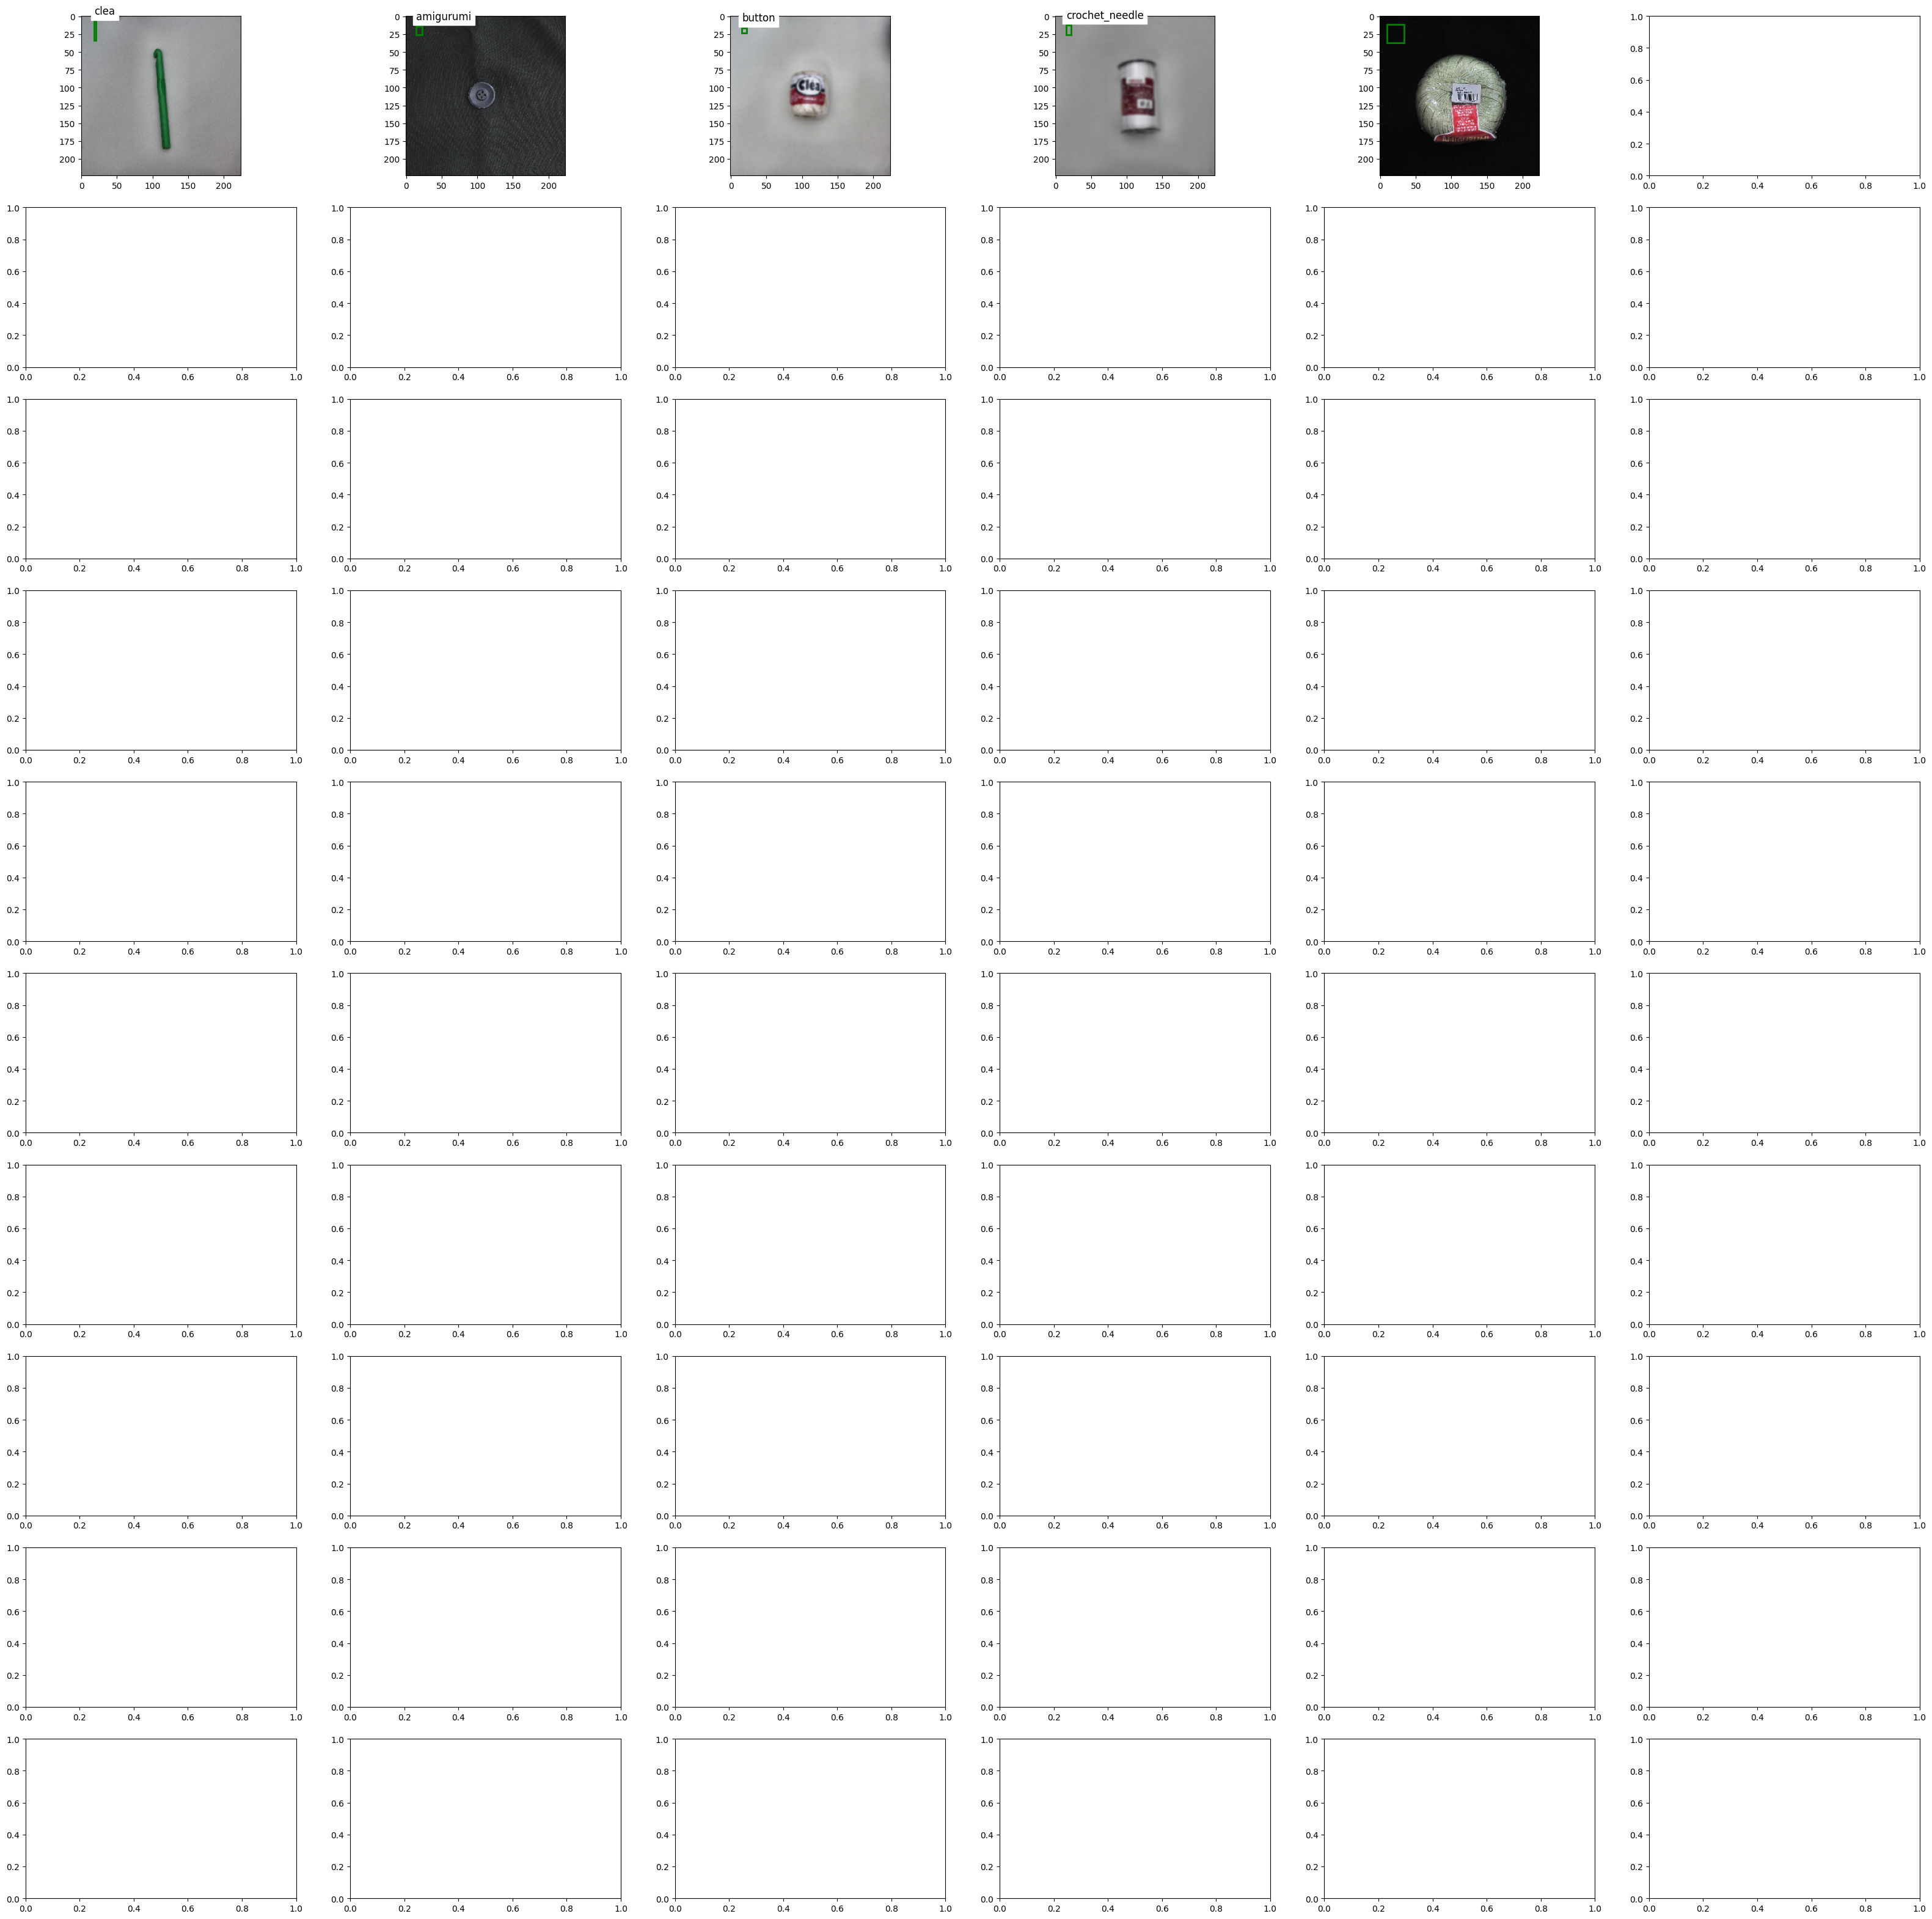

In [16]:
fig, axes = plt.subplots(10, 6, figsize=(40, 40))
for i, ax in enumerate(axes.flat):
    image = x_test[i]

    bbox = (predicted_bboxes[i] / 224.0) * 40
    predicted_class = predicted_classes[i]

    ax.imshow(image)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                             linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1] - 10, f'{class_labels[predicted_class]}', fontsize=12, backgroundcolor='white')

plt.tight_layout()
plt.show()

KeyError: np.int64(0)

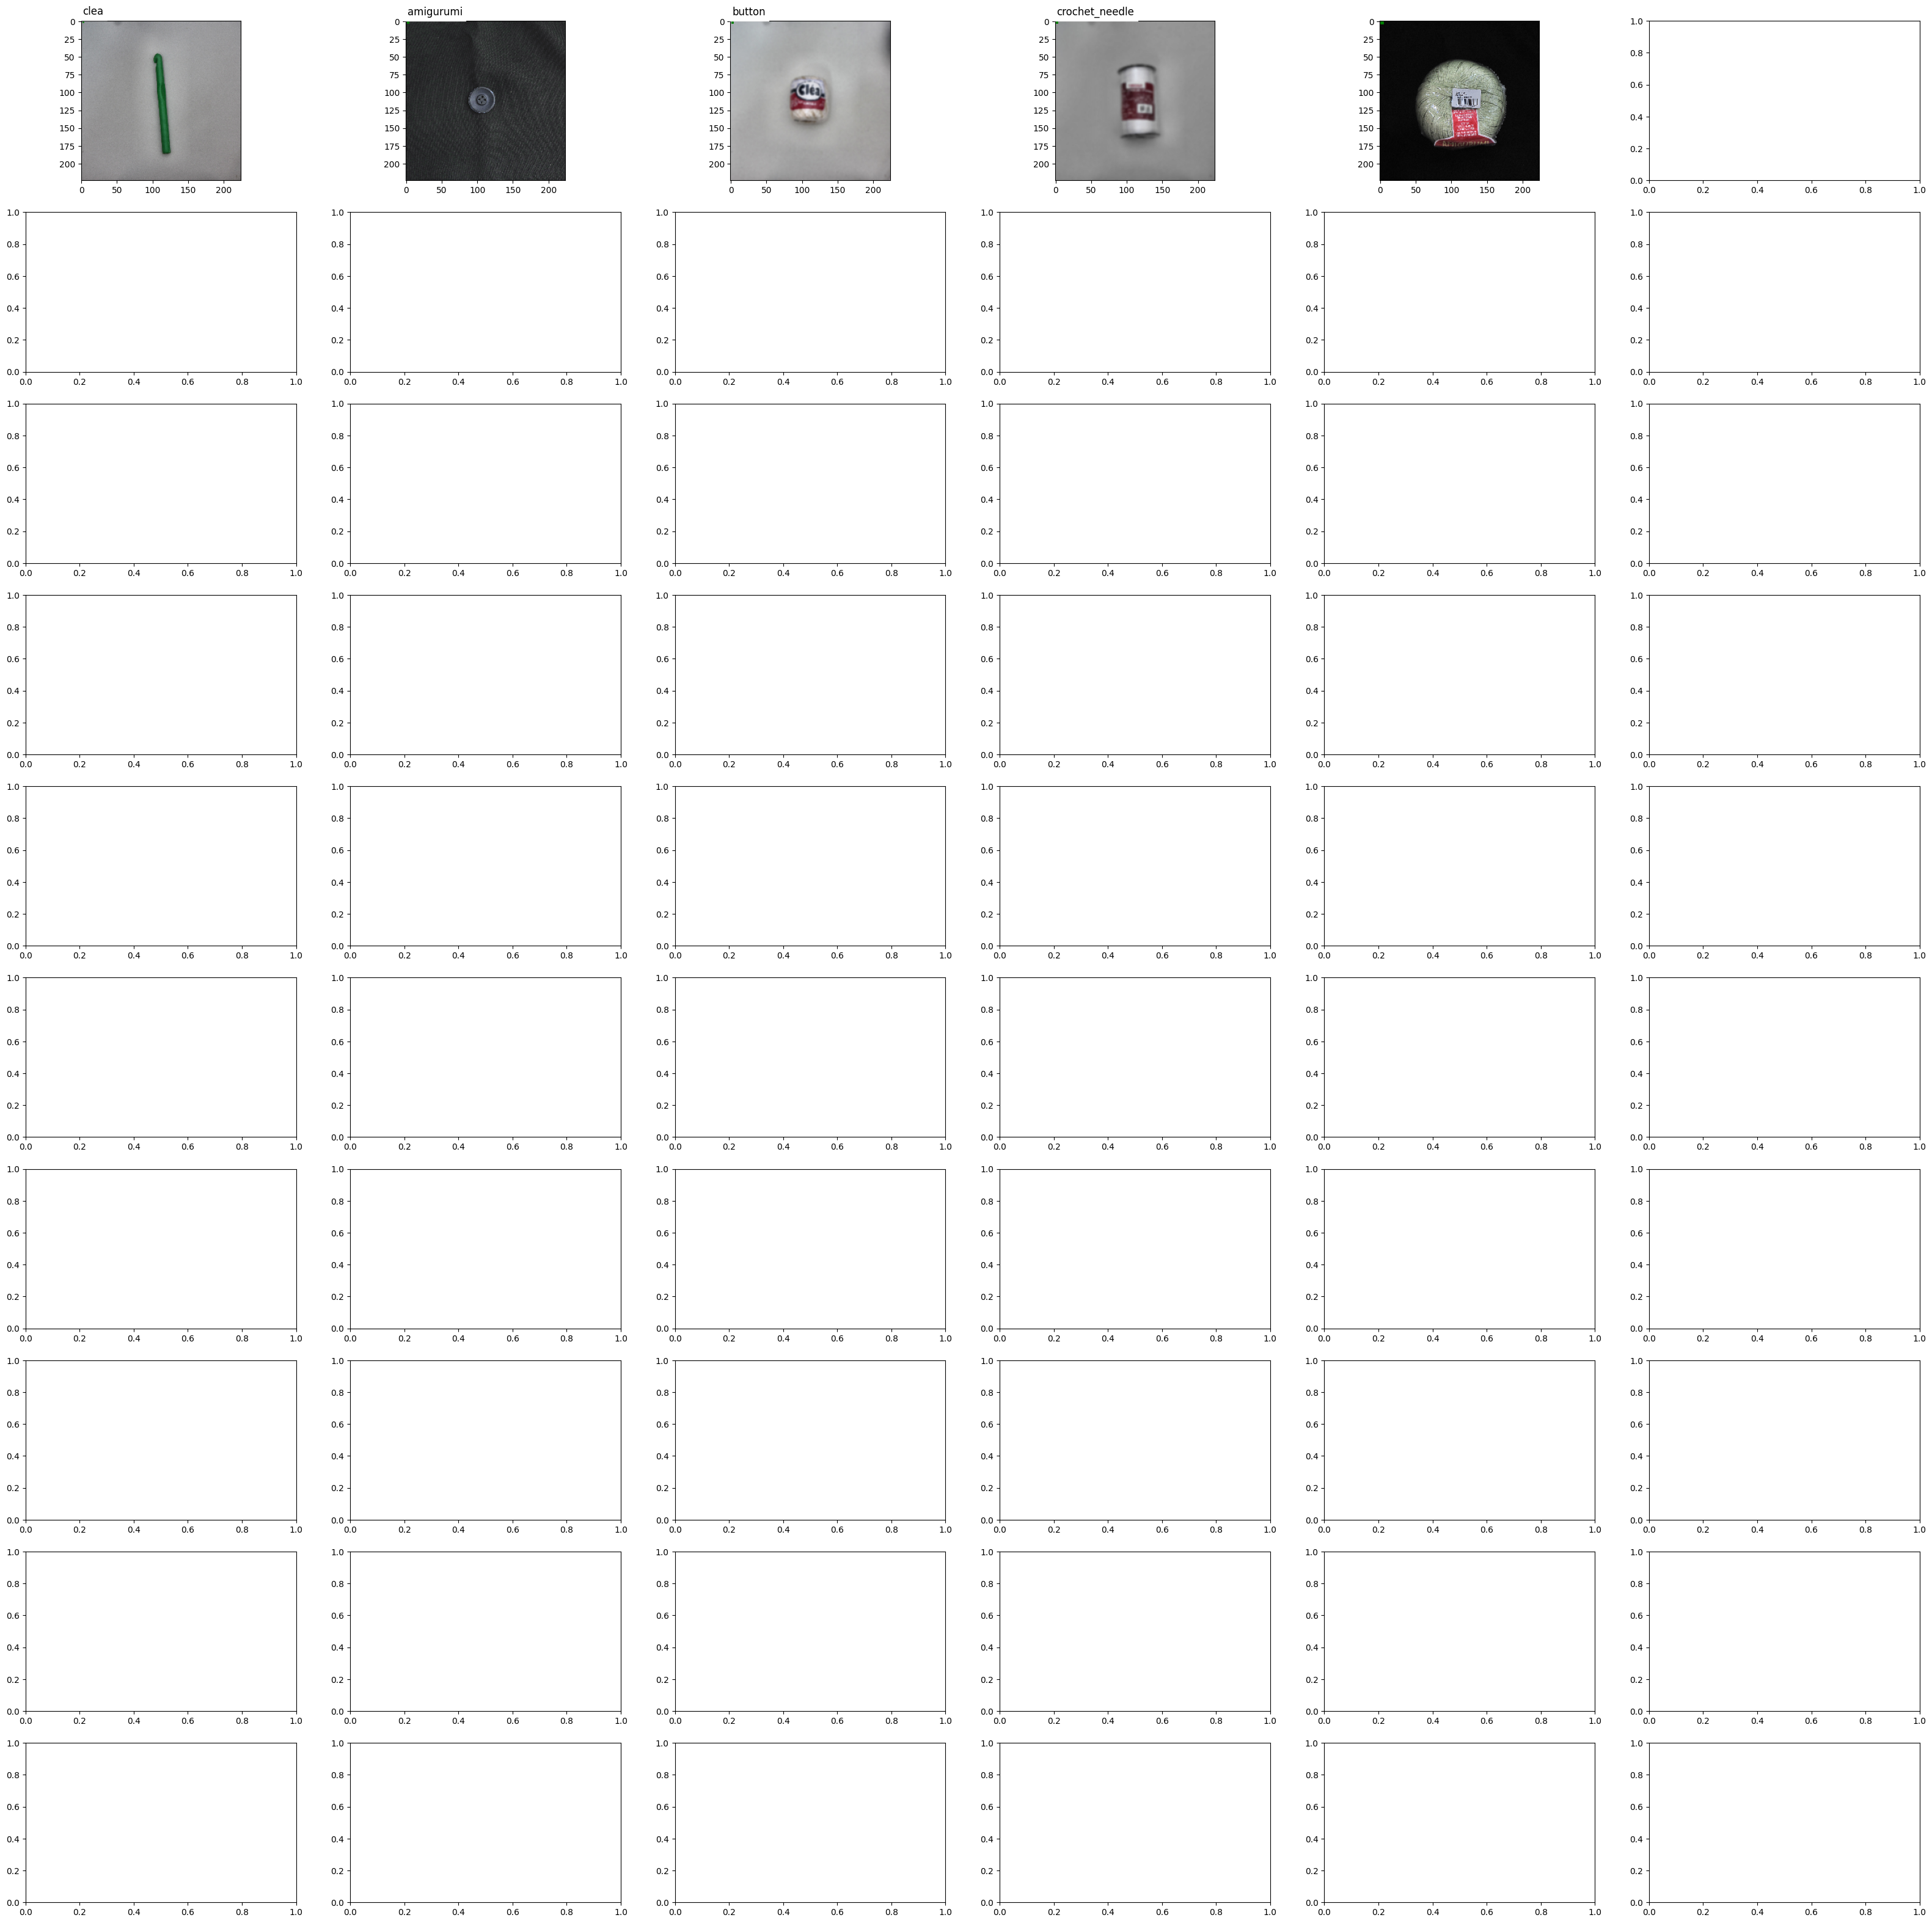

In [17]:
fig, axes = plt.subplots(10, 6, figsize=(40, 40))
for i, ax in enumerate(axes.flat):
    image = x_test[i]  # Imagem original

    bbox = predicted_bboxes[i]  # Bounding box [x_min, y_min, width, height]
    predicted_class = predicted_classes[i]  # Classe predita para a imagem

    # Exibe a imagem
    ax.imshow(image)

    # Ajusta o tamanho da bounding box
    img_height, img_width = image.shape[:2]  # Tamanho da imagem original
    display_width, display_height = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()).size
    scale_x = display_width / img_width
    scale_y = display_height / img_height

    adjusted_bbox = [
        bbox[0] * scale_x,  # x_min
        bbox[1] * scale_y,  # y_min
        bbox[2] * scale_x,  # width
        bbox[3] * scale_y   # height
    ]

    # Adiciona a bounding box redimensionada
    rect = patches.Rectangle((adjusted_bbox[0], adjusted_bbox[1]), adjusted_bbox[2], adjusted_bbox[3], 
                             linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

    # Adiciona o texto com a classe
    ax.text(adjusted_bbox[0], adjusted_bbox[1] - 10, f'{class_labels[predicted_class]}', 
            fontsize=12, backgroundcolor='white')

plt.tight_layout()
plt.show()